In [1]:
## importing the "Complications and Deaths Hospital" dataset with the three columns of interest
## "Provider ID" is a unique identifier to each hospital
## "Measure Name" is a column that contains the name of the complications.
## Score is a column that contains the score for each complication on the same row
## pivot_table was used to convert complications in the column "Measure Name" from rows to columns and have one "Provier ID" in each row.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path = "C:/Users/rab/Downloads/Hospital_Revised_Flatfiles"
df = pd.read_csv(path+"/Complications_and_Deaths__Hospital.csv", usecols=["Provider ID","Measure Name","Score"], 
                na_values="Not Available")

dff = df.pivot_table(index="Provider ID", columns="Measure Name", values="Score", dropna=False)

## dropping out Non_Surgical complications
## then renaming surgical complications with shorter names

dff.drop(["Acute Myocardial Infarction (AMI) 30-Day Mortality Rate","Death rate for stroke patients",
         "Pressure sores","Infections from a large venous catheter","Accidental cuts and tears from medical treatment",
         "Collapsed lung due to medical treatment","Serious complications","Death rate for chronic obstructive pulmonary disease (COPD) patients",
         "Heart failure (HF) 30-Day Mortality Rate","Pneumonia (PN) 30-Day Mortality Rate"], axis=1, inplace=True)

df_surg = dff.rename(columns={"A wound that splits open  after surgery on the abdomen or pelvis":"Dehiscence",
                   "Blood stream infection after surgery":"PostOpSepsis",
                   "Broken hip from a fall after surgery":"PostOpHipFx",
                   "Death rate for CABG":"CABGmortality",
                   "Deaths among Patients with Serious Treatable Complications after Surgery":"SerCOndPostOpMortality",
                   "Rate of complications for hip/knee replacement patients":"JntRepComp",
                   "Serious blood clots after surgery":"PostOpVTE"})

print("The shape of the initial dataset:",df_surg.shape)

## calculating the number of rows with at least on NaN value
## calculating the number of NaN values for each post-operative complication (surgical complication)  as 
## demonstrated in the serie S with the index corresponding to complications
counter_nan = 0
for i, r in df_surg.iterrows():
    if r.isnull().sum()>0:
        counter_nan = counter_nan + 1
print("Number of rows with at least one NaN values:", counter_nan)

col = []
num = []
for ii, rr in df_surg.iteritems():
    col.append(ii)
    num.append(rr.isnull().sum())
    
S = pd.Series(num, index=col).sort_values(ascending=False)
print("The number of NaN values for each complication is below:")
print(S)

    

The shape of the initial dataset: (4812, 7)
Number of rows with at least one NaN values: 3847
The number of NaN values for each complication is below:
CABGmortality             3778
SerCOndPostOpMortality    2998
PostOpSepsis              2513
Dehiscence                2286
JntRepComp                2052
PostOpHipFx               1962
PostOpVTE                 1846
dtype: int64


C:\Users\rab\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.06, right=0.06
  'left=%s, right=%s') % (left, right))
C:\Users\rab\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.06, top=0.06
  'bottom=%s, top=%s') % (bottom, top))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2B398DEF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001D2B85F9A20>]], dtype=object)

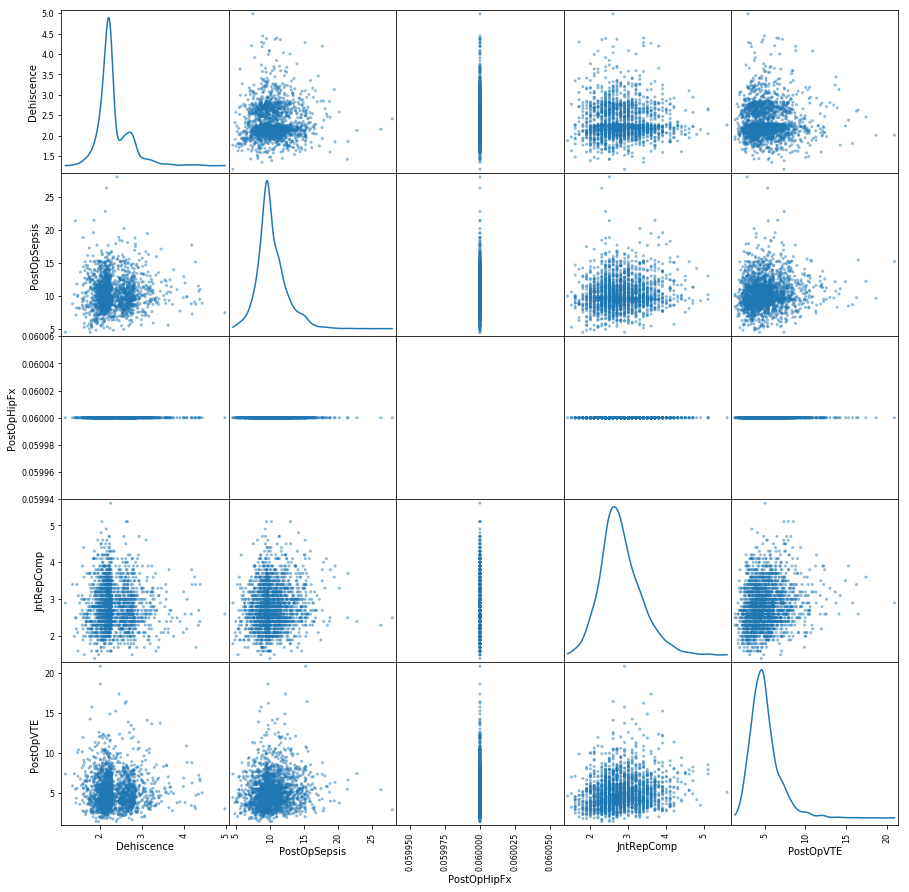

In [2]:
## dropping two complications given high rate of NaN values
## visual exploration of the data distribution

df_surg.drop(["CABGmortality","SerCOndPostOpMortality"], axis=1, inplace=True)
pd.plotting.scatter_matrix(df_surg, figsize=(15,15), diagonal="kde")

In [3]:
## dropping "PostOpHipFx" given that its distribution is uniform
df_surg.drop("PostOpHipFx", axis=1, inplace=True)
df_surg.shape

(4812, 4)

In [4]:
## dropping any row with a NaN value
print(df_surg.columns)
df_surg.dropna(axis=0, how="any", inplace=True)

## final shape of the data to evaluate
print(df_surg.shape)
print(df_surg.head(5))

Index(['Dehiscence', 'PostOpSepsis', 'JntRepComp', 'PostOpVTE'], dtype='object', name='Measure Name')
(2043, 4)
Measure Name  Dehiscence  PostOpSepsis  JntRepComp  PostOpVTE
Provider ID                                                  
10001               2.72          5.72         4.2       3.32
10005               2.11          9.18         3.1       5.63
10011               2.51          9.66         3.6       7.18
10016               1.95         10.26         2.4       2.84
10023               3.00          9.97         2.7       1.94


In [7]:
## preprocessing by removing the top and bottom 2.5% of the outliers
for col in df_surg.keys():
    wo_outliers = df_surg[(df_surg[col]>=np.percentile(df_surg[col],[2.5,97.5])[0]) & 
                          (df_surg[col]<=np.percentile(df_surg[col],[2.5,97.5])[1])]

print(wo_outliers.shape)
wo_outliers.head()

(1941, 4)


Measure Name,Dehiscence,PostOpSepsis,JntRepComp,PostOpVTE
Provider ID,,,,
10001,2.72,5.72,4.2,3.32
10005,2.11,9.18,3.1,5.63
10011,2.51,9.66,3.6,7.18
10016,1.95,10.26,2.4,2.84
10024,2.01,11.66,2.0,3.01


In [8]:
## importing two algorithms KMeans and MeanShift for unsupervised learning 
## implementing Meanshift first
## finding the number of clusters that MeanShift returns

from sklearn.cluster import KMeans, MeanShift
data = wo_outliers.copy()
index=wo_outliers.index.tolist()
m_shift = MeanShift()
m_shift.fit(data.values)
cent = m_shift.cluster_centers_
print(len(cent))

4


In [9]:
## finding the number of samples associated with each label
lab_MeanS = m_shift.labels_
lab_MeanS = pd.Series(lab_MeanS, index=data.index.tolist(), name="labels")
dataMS_labeled = pd.concat([data, lab_MeanS], axis=1)
print(dataMS_labeled["labels"].value_counts())


0    1889
1      50
3       1
2       1
Name: labels, dtype: int64


In [11]:
## since MeanShift is not the right algorithm
## I tried KMeans and calculated the silhouette_score to find the ideal number of clusters
from sklearn.metrics import silhouette_score
for n in range(2,6):
    clusterer = KMeans(n_clusters=n, random_state=9)
    clusterer.fit(data.values)
    preds = clusterer.predict(data.values)
    score = silhouette_score(data, preds)
    print(score)

0.39342460845
0.331910330197
0.307750815961
0.290645582601


In [12]:
## Implementing KMeans with two clusters based on the silhouette score above.
two_clusters = KMeans(n_clusters=2, random_state=9)
two_clusters.fit(data)
labels_two = two_clusters.labels_

In [13]:
## adding the labels as a column to the dataframe
lab = pd.Series(labels_two, index=data.index.tolist(), name="labels")
data_labeled_two = pd.concat([data, lab], axis=1)
print(data_labeled_two.shape)
data_labeled_two.head()

(1941, 5)


,Dehiscence,PostOpSepsis,JntRepComp,PostOpVTE,labels
Provider ID,,,,,
10001,2.72,5.72,4.2,3.32,0
10005,2.11,9.18,3.1,5.63,0
10011,2.51,9.66,3.6,7.18,0
10016,1.95,10.26,2.4,2.84,0
10024,2.01,11.66,2.0,3.01,1


In [14]:
## extracting the first cluster from the dataset
first_segm_2clust = data_labeled_two[data_labeled_two["labels"]==0].drop("labels", axis=1)
print(first_segm_2clust.shape)

## grouping the means for each complication in the first cluster in a serie
first_ser_2clust = first_segm_2clust.describe().loc["mean",:]

## extracting the second cluster from the dataset
sec_segm_2clust = data_labeled_two[data_labeled_two["labels"]==1].drop("labels", axis=1)
print(sec_segm_2clust.shape)

## grouping the means for each complication in the second cluster in a serie
sec_ser_2clust = sec_segm_2clust.describe().loc["mean",:]


(1429, 4)
(512, 4)


C:\Users\rab\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


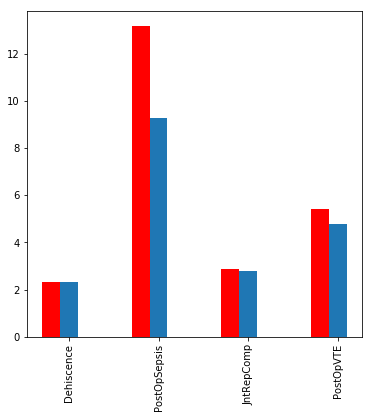

In [15]:
## using the means series from above and graphing a side by side bar chart
bar_width=0.4
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(np.linspace(2,8,4), first_ser_2clust, bar_width, tick_label=first_ser_2clust.index)
plt.xticks(rotation="vertical")
ax.bar(np.linspace(2,8,4)-bar_width, sec_ser_2clust, bar_width, color="r")
#ax.bar(np.linspace(2,8,4)+bar_width, thrd_ser, bar_width, color="g")

fig.show()

Given the large number of samples (1429) in the "GOOD" cluster (blue-since it has lower complications score) compared the "BAD" cluster (number of samples 512). I will try now KMeans with three clusters hoping the "good" cluster will stand out better and shrink in size.

In [16]:
final_clusterer = KMeans(n_clusters=3, random_state=9)
final_clusterer.fit(data.values)
labels = final_clusterer.labels_
lab = pd.Series(labels, index=data.index.tolist(), name="labels")
data_labeled = pd.concat([data, lab], axis=1)
data_labeled.head()


,Dehiscence,PostOpSepsis,JntRepComp,PostOpVTE,labels
Provider ID,,,,,
10001,2.72,5.72,4.2,3.32,0
10005,2.11,9.18,3.1,5.63,1
10011,2.51,9.66,3.6,7.18,1
10016,1.95,10.26,2.4,2.84,0
10024,2.01,11.66,2.0,3.01,0


In [17]:
## extracting the first cluster from the dataset
first_segm = data_labeled[data_labeled["labels"]==0].drop("labels", axis=1)
print(first_segm.shape)

## grouping the means for each complication in the first cluster in a serie
first_ser = first_segm.describe().loc["mean",:]

## extracting the second cluster from the dataset
sec_segm = data_labeled[data_labeled["labels"]==1].drop("labels", axis=1)
print(sec_segm.shape)

## grouping the means for each complication in the second cluster in a serie
sec_ser = sec_segm.describe().loc["mean",:]

## extracting the third cluster from the dataset
thrd_segm = data_labeled[data_labeled["labels"]==2].drop("labels", axis=1)
print(thrd_segm.shape)

## grouping the means for each complication in the third cluster in a serie
thrd_ser = thrd_segm.describe().loc["mean",:]

(1045, 4)
(534, 4)
(362, 4)


C:\Users\rab\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


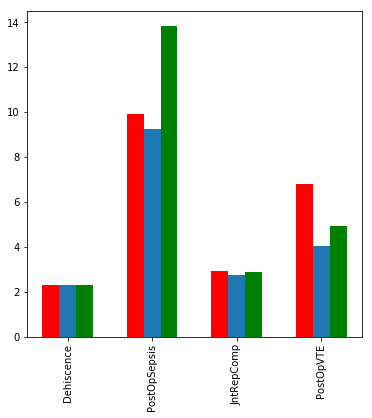

In [19]:
## using the means series from above and graphing a side by side bar chart

bar_width=0.4
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(np.linspace(2,8,4), first_ser, bar_width, tick_label=first_ser.index)
plt.xticks(rotation="vertical")
ax.bar(np.linspace(2,8,4)-bar_width, sec_ser, bar_width, color="r")
ax.bar(np.linspace(2,8,4)+bar_width, thrd_ser, bar_width, color="g")

fig.show()

In [20]:
## grouping the "Provider ID" of the blue cluster ("Good surgical cluster") into one list.
## grouping the "Provider ID" of the red and green ("Bad surgical clusters") clusters into another list

good_surg_frame_ind = first_segm.index.tolist()
bad_surg_frame_ind = sec_segm.index.tolist() + thrd_segm.index.tolist()

print(len(good_surg_frame_ind))
print(len(bad_surg_frame_ind))

1045
896


Here I move to the dataset "Hospital General Information" in order to tally the number of Government, Proprietary and Non-Profit hospitals with their associated "Provider ID"


In [21]:
## pivoting the table to convert the values of "Hospital Ownership" into columns. 
## Each column value will the "Provider ID" or NaN associated the particular type of ownership

df_hosp = pd.read_csv(path+"/Hospital_General_Information.csv", encoding="ISO-8859-1", usecols=["Provider ID",
                                                                                               "Hospital Ownership"])
print(df_hosp.shape)
df_hosp_piv = df_hosp.pivot(columns="Hospital Ownership", values="Provider ID")
print(df_hosp_piv.columns)
#print(df_hosp_piv.head(5))

(4812, 2)
Index(['Government - Federal', 'Government - Hospital District or Authority',
       'Government - Local', 'Government - State', 'Physician', 'Proprietary',
       'Tribal', 'Voluntary non-profit - Church',
       'Voluntary non-profit - Other', 'Voluntary non-profit - Private'],
      dtype='object', name='Hospital Ownership')


In [22]:
## removing the NaN values from each column and building an array for each type of ownnership containing all the
## "Provider ID"s associated with that ownership. See example below.

Gov_Federal = np.array(df_hosp_piv["Government - Federal"])
Gov_Fed = Gov_Federal[~np.isnan(Gov_Federal)]
Gov_Fed = np.array(Gov_Fed, dtype=np.int64)

Gov_HD = np.array(df_hosp_piv["Government - Hospital District or Authority"])
Gov_HD = Gov_HD[~np.isnan(Gov_HD)]
Gov_HD = np.array(Gov_HD, dtype=np.int64)

Gov_Loc = np.array(df_hosp_piv["Government - Local"])
Gov_Loc = Gov_Loc[~np.isnan(Gov_Loc)]
Gov_Loc = np.array(Gov_Loc, dtype=np.int64)

Gov_St = np.array(df_hosp_piv["Government - State"])
Gov_St = Gov_St[~np.isnan(Gov_St)]
Gov_St = np.array(Gov_St, dtype=np.int64)

Physic = np.array(df_hosp_piv["Physician"])
Physic = Physic[~np.isnan(Physic)]
Physic = np.array(Physic, dtype=np.int64)

Prop = np.array(df_hosp_piv["Proprietary"])
Prop = Prop[~np.isnan(Prop)]
Prop = np.array(Prop, dtype=np.int64)

Trib = np.array(df_hosp_piv["Tribal"])
Trib = Trib[~np.isnan(Trib)]
Trib = np.array(Trib, dtype=np.int64)

Vol_Chu = np.array(df_hosp_piv["Voluntary non-profit - Church"])
Vol_Chu = Vol_Chu[~np.isnan(Vol_Chu)]
Vol_Chu = np.array(Vol_Chu, dtype=np.int64)

Vol_Oth = np.array(df_hosp_piv["Voluntary non-profit - Other"])
Vol_Oth = Vol_Oth[~np.isnan(Vol_Oth)]
Vol_Oth = np.array(Vol_Oth, dtype=np.int64)

Vol_Priv = np.array(df_hosp_piv["Voluntary non-profit - Private"])
Vol_Priv = Vol_Priv[~np.isnan(Vol_Priv)]
Vol_Priv = np.array(Vol_Priv, dtype=np.int64)

Vol_Priv

array([ 10007,  10011,  10016, ..., 670108, 670111, 650003], dtype=int64)

In [23]:
## counting the number of Each Ownership in Each Cluster

print("Number of Gov_Fed in Good Cluster:", len([x for x in good_surg_frame_ind if x in Gov_Fed.tolist()]))
print("Number of Gov_Fed in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Gov_Fed.tolist()]))

print("Number of Gov_HD in Good Cluster:", len([x for x in good_surg_frame_ind if x in Gov_HD.tolist()]))
print("Number of Gov_HD in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Gov_HD.tolist()]))

print("Number of Gov_Loc in Good Cluster:", len([x for x in good_surg_frame_ind if x in Gov_Loc.tolist()]))
print("Number of Gov_Loc in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Gov_Loc.tolist()]))

print("Number of Gov_St in Good Cluster:", len([x for x in good_surg_frame_ind if x in Gov_St.tolist()]))
print("Number of Gov_St in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Gov_St.tolist()]))

print("Number of Physicians in Good Cluster:", len([x for x in good_surg_frame_ind if x in Physic.tolist()]))
print("Number of Physicians in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Physic.tolist()]))

print("Number of Prop in Good Cluster:", len([x for x in good_surg_frame_ind if x in Prop.tolist()]))
print("Number of Prob in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Prop.tolist()]))

print("Number of Trib in Good Cluster:", len([x for x in good_surg_frame_ind if x in Trib.tolist()]))
print("Number of Trib in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Trib.tolist()]))

print("Number of Vol Chu in Good Cluster:", len([x for x in good_surg_frame_ind if x in Vol_Chu.tolist()]))
print("Number of Vol Chu in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Vol_Chu.tolist()]))

print("Number of Vol Oth in Good Cluster:", len([x for x in good_surg_frame_ind if x in Vol_Oth.tolist()]))
print("Number of Vol Oth in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Vol_Oth.tolist()]))

print("Number of Vol Priv in Good Cluster:", len([x for x in good_surg_frame_ind if x in Vol_Priv.tolist()]))
print("Number of Vol Priv in Bad Cluster:", len([x for x in bad_surg_frame_ind if x in Vol_Priv.tolist()]))

Number of Gov_Fed in Good Cluster: 6
Number of Gov_Fed in Bad Cluster: 1
Number of Gov_HD in Good Cluster: 75
Number of Gov_HD in Bad Cluster: 51
Number of Gov_Loc in Good Cluster: 47
Number of Gov_Loc in Bad Cluster: 29
Number of Gov_St in Good Cluster: 7
Number of Gov_St in Bad Cluster: 16
Number of Physicians in Good Cluster: 4
Number of Physicians in Bad Cluster: 8
Number of Prop in Good Cluster: 204
Number of Prob in Bad Cluster: 145
Number of Trib in Good Cluster: 0
Number of Trib in Bad Cluster: 0
Number of Vol Chu in Good Cluster: 102
Number of Vol Chu in Bad Cluster: 99
Number of Vol Oth in Good Cluster: 110
Number of Vol Oth in Bad Cluster: 107
Number of Vol Priv in Good Cluster: 490
Number of Vol Priv in Bad Cluster: 440


In [24]:
Gov_good = 6+75+47+7
Gov_bad = 1+51+29+16
Vol_good = 102+110+490
Vol_bad = 99+107+440
print("Gov Good:",Gov_good, "Gov_bad:",Gov_bad, "Vol_good:",Vol_good, "Vol_bad:", Vol_bad)

Gov Good: 135 Gov_bad: 97 Vol_good: 702 Vol_bad: 646


In [25]:
## I produced the contingency table below based on the numbers above
## I didn't acount for Tribal and Physicians' Ownership due to their small number

pd.DataFrame([[135,204,702],[97,145,646]], columns=["Government","Proprietary","Non-Profit"],
             index=["Good cluster","Bad cluster"])

,Government,Proprietary,Non-Profit
Good cluster,135,204,702
Bad cluster,97,145,646


In [66]:
print("Ratio of Proprietary hospitals in Good cluster", round(204/(135+204+702),3),"            Expected Ratio:",0.181)
print("Ratio of Proprietary hospitals in Bad cluster", round(145/(97+145+646),3),"             Expected Ratio:",0.181)

print("Ratio of Government hospitals in Good cluster", round(135/(135+204+702),3),"              Expected Ratio:",0.12)
print("Ratio of Government hospitals in Bad cluster", round(97/(97+145+646),3),     "              Expected Ratio:",0.12)

print("Ratio of Voluntary (non-profit) hospitals in Good cluster", round(702/(135+204+702),3), " Expected Ratio:",0.70)
print("Ratio of Voluntary (non-profit) hospitals in Bad cluster", round(646/(97+145+646),3), "  Expected Ratio:",0.70)

Ratio of Proprietary hospitals in Good cluster 0.196             Expected Ratio: 0.181
Ratio of Proprietary hospitals in Bad cluster 0.163              Expected Ratio: 0.181
Ratio of Government hospitals in Good cluster 0.13               Expected Ratio: 0.12
Ratio of Government hospitals in Bad cluster 0.109               Expected Ratio: 0.12
Ratio of Voluntary (non-profit) hospitals in Good cluster 0.674  Expected Ratio: 0.7
Ratio of Voluntary (non-profit) hospitals in Bad cluster 0.727   Expected Ratio: 0.7


The ratios above showed that the Proprietary and Government Hospitals are more prevalent in the "Good Cluster" than expected, but the Non-Profit hospitals are less prevalent in the "Good Cluster" than expected.
Therefore, I ran the Chi test for independence of variables below.

In [39]:
from scipy.stats import chi2_contingency
chi2_contingency([[135,204,702],[97,145,646]])

(6.4299066184513718,
 0.040157208751023667,
 2,
 array([[ 125.20062208,  188.34059098,  727.45878694],
        [ 106.79937792,  160.65940902,  620.54121306]]))

Based on the result above, we can say with 96% confidence that "Type of hospital ownership" and "Post-surgical complications" are not independent variables, and that "non-profit" hospitals tend to be more prevalent in the cluster with more post-operative complications.

Validation of the above findings. I used the dataset "Hospital General Information" that contains an ordinal variable called "Mortality national comparison" for each hospital.
I will group the "government hospitals" together and do the same for the "proprietary" and "non-profit/voluntary" hospitals and see if there is a dependence between the mortality variable on one side the type of ownership on the other side.

In [40]:
## grouping the different subcategories into one category of ownership

df_val = pd.read_csv(path+"/Hospital_General_Information.csv", encoding="ISO-8859-1",
                     usecols=["Provider ID", "Hospital Ownership", "Mortality national comparison"])


df_val.replace(to_replace={"Hospital Ownership":{"Government - Hospital District or Authority":"Gov", "Government - State":"Gov",
                                                 "Government - Federal":"Gov", "Voluntary non-profit - Private":"NonProfit",
                                                 "Voluntary non-profit - Church":"NonProfit", "Voluntary non-profit - Other":"NonProfit",
                                                "Government - Local":"Gov"}}, inplace=True)

df_val.head(5)


,Provider ID,Hospital Ownership,Mortality national comparison
0,10001,Gov,Same as the national average
1,10005,Gov,Below the national average
2,10006,Gov,Below the national average
3,10007,NonProfit,Same as the national average
4,10008,Proprietary,Same as the national average


In [41]:
## doing a groupby to form a contingency table

table = df_val.groupby(by=["Hospital Ownership","Mortality national comparison"]).count().unstack("Mortality national comparison")
table

Provider ID  \
Mortality national comparison Above the national average   
Hospital Ownership                                         
Gov                                                 24.0   
NonProfit                                          298.0   
Physician                                            4.0   
Proprietary                                         74.0   
Tribal                                               NaN   

                                                                        \
Mortality national comparison Below the national average Not Available   
Hospital Ownership                                                       
Gov                                                 65.0         448.0   
NonProfit                                          211.0         631.0   
Physician                                            NaN          54.0   
Proprietary                                         65.0         212.0   
Tribal                                               NaN           7.0   

                                                            
Mortality national comparison Same as the national average  
Hospital Ownership                                          
Gov                                                  541.0  
NonProfit                                           1717.0  
Physician                                             10.0  
Proprietary                                          449.0  
Tribal                                                 2.0

In [42]:
## dropping Tribal and Physician ownership

table.drop(["Physician", "Tribal"], axis=0, inplace=True)

In [43]:
## dropping "Not Available" column

table.drop("Not Available", axis=1, level=1, inplace=True)
print(table)

Provider ID  \
Mortality national comparison Above the national average   
Hospital Ownership                                         
Gov                                                 24.0   
NonProfit                                          298.0   
Proprietary                                         74.0   

                                                          \
Mortality national comparison Below the national average   
Hospital Ownership                                         
Gov                                                 65.0   
NonProfit                                          211.0   
Proprietary                                         65.0   

                                                            
Mortality national comparison Same as the national average  
Hospital Ownership                                          
Gov                                                  541.0  
NonProfit                                           1717.0  
Proprietary                                          449.0

In [68]:
print("Ratio of Government with mortality below national average", round(65.0/(24.0+65.0+541.0),3), "  Expected Ratio:",0.183)
print("Ratio of Non-Profit with mortality below national average", round(211.0/(298.0+211.0+1717.0),3), "  Expected ratio:",0.099)
print("Ratio of Proprietary with mortality below national average", round(65.0/(74.0+65.0+449.0),3), " Expected ratio:", 0.099)

Ratio of Government with mortality below national average 0.103   Expected Ratio: 0.183
Ratio of Non Profit with mortality below national average 0.095   Expected ratio: 0.099
Ratio of Proprietary with mortality below national average 0.111  Expected ratio: 0.099


In [69]:
print("Ratio of Government with mortality above national average", round(24.0/(24.0+65.0+541.0),3), "   Expected Ratio:",0.11)
print("Ratio of Non-Profit with mortality above national average", round(298.0/(298.0+211.0+1717.0),3),"   Expected Ratio:",0.11)
print("Ration of Proprietary with mortality above national average", round(74.0/(74.0+65.0+449.0),3)," Expected Ratio:",0.11)

Ratio of Government with mortality above national average 0.038    Expected Ratio: 0.11
Ratio of Non Profit with mortality above national average 0.134    Expected Ratio: 0.11
Ration of Proprietary with mortality above national average 0.126  Expected Ratio: 0.11


Based on the ratios above, the Government hospitals seem to outperform Non-Profit hospital. Proprietary hospitals seemed to outperform Non-Profit by a lesser extent.
Therefore, I used the chi test below to check for independency of the two variables "mortaliy nationwide" on one side and "type of ownership" on the other side.

In [60]:
chi2_contingency([[24.0,65.0, 541.0],[298.0, 211.0, 1717.0],[74.0, 65.0, 449.0]])

(46.427210241294695,
 2.0068681780327671e-09,
 4,
 array([[   72.43902439,    62.37804878,   495.18292683],
        [  255.95121951,   220.40243902,  1749.64634146],
        [   67.6097561 ,    58.2195122 ,   462.17073171]]))

The chi test aboves revealed with a great confidence that the two variables were not independent.
Therefore, we could say that Government hospitals followed by Private Hospitals (albeit to a lesser extent) have a lower mortality nationwide when compared to Non-Profit hospitals.

Based on the data in the clusters above, the share for each category of ownership is listed below:

**Good Cluster**               
non_profit=67%       
government = 13%       
private=20% 

**Bad Cluster**               
non_profit=73%       
government = 11%       
private=16% 


The visualization below showed how a small change in the Ownership share will be reflected in a substantial drop in the mean score of complications.

C:\Users\rab\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


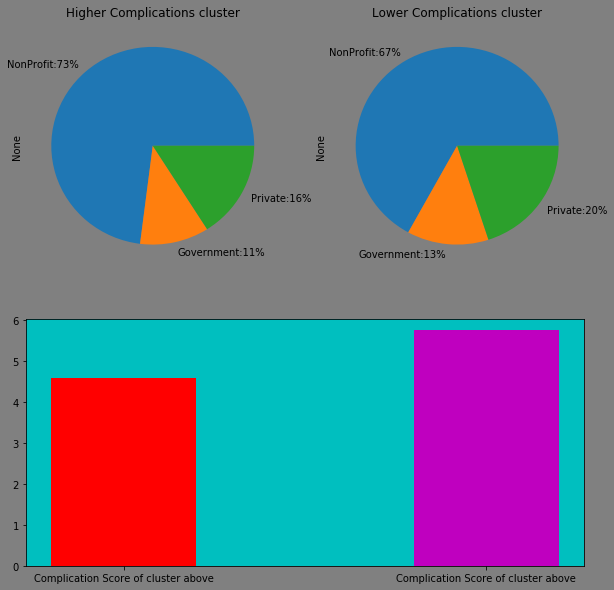

In [175]:
## caclulating the mean score for the two clusters
col_good = round(first_ser.mean(),3)
col_bad = round((sec_ser.mean()+thrd_ser.mean())/2,3)
print(col_good, col_bad)

Good_pie = [67,13,20]
labels_g=["NonProfit:67%","Government:13%","Private:20%"]

Bad_pie = [73,11,16]
labels_b=["NonProfit:73%","Government:11%","Private:16%"]

fig = plt.figure(figsize=(10,10),facecolor='gray')
ax1 = plt.subplot(2,2,1)  
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2,facecolor='c') 

pd.Series(Good_pie).plot(kind="pie", labels=labels_g, title="Lower Complications cluster", ax=ax2)
pd.Series(Bad_pie).plot(kind="pie", labels=labels_b, title="Higher Complications cluster",ax=ax1)
ax3.bar([1,2],height=[col_good,col_bad], width=0.4,color=["r","m"], 
        tick_label=["Complication Score of cluster above"])
fig.show()

